In [28]:
import numpy as np
import pandas as pd
import xarray as xr
import netCDF4
from erddapy import ERDDAP
import json
import re

Pull in the processed inventory

In [29]:
ra = "sccoos"

#
# df_cruise = df[df['Station Description'] == 'Chesapeake Bay WQ Cruise Data ']
#
#df_aws = df[df['Station ID'] == 'Humboldt']
# #url = 'http://tds.glos.us/thredds/dodsC/buoy_agg_standard/OMOECC_E1/OMOECC_E1.ncml'
# #url = 'http://tds.glos.us/thredds/dodsC/buoy_agg_standard/45186/45186.ncml'
# #url = 'http://tds.glos.us/thredds/dodsC/buoy_agg_standard/bgsusd2/bgsusd2.ncml'
# url = 'http://oos.soest.hawaii.edu/thredds/dodsC/hioos/nss/ns12agg'
# print(url)
# ds = xr.open_dataset(url)
# #ds = netCDF4.Dataset(url,'r')
# title = ds.title
# start_time = np.datetime_as_string(ds.time.min().values, unit='D')
# end_time = np.datetime_as_string(ds.time.max().values, unit='D')
# print('Duration: %s - %s' % (np.datetime_as_string(ds.time.min().values, unit='D'),
#                              np.datetime_as_string(ds.time.max().values, unit='D'))
#       )

# Try glos web server
# url = 'https://glbuoys.glos.us/tools/export?ftype=csv&data_type=buoy&units=eng&locs=OMOECC_E1&params=Water_Temperature_at_Surface|dissolved_oxygen_saturation|water_conductivity|ysi_turbidity&tperiod=custom&date_start=2020-01-01&date_end=2020-12-31&avg_ivld=none'
# df = erddapy.ERDDAP.to_pandas(url)

## using ERDDAP to look for stations
# check out http://data.glos.us/erddap/tabledap/allDatasets.htmlTable?datasetID%2Ctitle%2CminTime%2CmaxTime&maxTime%3E=2020-01-01&maxTime%3C=2020-12-31&orderBy(%22maxTime%22)
# that lists out all the GLOS stations with the maximum time of observations within the year 2020 (on their ERDDAP).


ra_clean = re.sub(r'[0-9]', '', ra) # remove number from RA 

df = pd.read_excel('2024/data/processed/%s.xlsx' % ra_clean.upper(), dtype=str)
df.head()

,RA,Station ID,WMO ID or NWS/CMAN ID,Station Long Name,Station Description,Latitude (dec deg),Longitude (dec deg),Platform Type,"Station Deployment (mm/yyyy, yyyy, < 5 yr, > 5 yr)","Currently Operational? (Y, N, O, U)",Platform Funder/Sponsor,"RA Funding Involvement (Yf, Yp, N)",Platform Operator/Owner,Operator Sector,Platform Maintainer,Data Manager,"Variable Names + water column depth of measurement in meters [CF_name (# m, # m) or CF_name (mult) or CF_name (# depths)].",Additional notes
0,SCCOOS,SW,TNWC1,Stearns Wharf,Automated Shore Station,34.4107,-119.6874,fixed,2005,Y,SCCOOS,Yf,UCSD,Academic,UCSD,Southern California Coastal Ocean Observing Sy...,"sea_water_temperature (2m), sea_water_pressure...",WMO ID In process. operated by Melissa Carter
1,SCCOOS,SMP,NaN,Santa Monica Pier,Automated Shore Station,34.0086,-118.4986,fixed,2005,Y,SCCOOS/City of LA/Santa Monica Bay Foundation,Yp,UCSD,Academic,UCSD,Southern California Coastal Ocean Observing Sy...,"sea_water_temperature (2m), sea_water_pressure...",WMO ID In process. operated by Melissa Carter
2,SCCOOS,NBP,NEWC1,Newport Beach Pier,Automated Shore Station,33.6073,-117.9289,fixed,2005,Y,SCCOOS,Yf,UCSD,Academic,UCSD,Southern California Coastal Ocean Observing Sy...,"sea_water_temperature (2m), sea_water_pressure...",WMO ID In process. operated by Melissa Carter
3,SCCOOS,SP,LJSC1,Scripps Pier,Automated Shore Station,32.867,-117.257,fixed,2005,Y,SCCOOS,Yf,UCSD,Academic,UCSD,Southern California Coastal Ocean Observing Sy...,"sea_water_temperature (2m), sea_water_pressure...",WMO ID In process. operated by Melissa Carter
4,SCCOOS,SP,LJSC1,Scripps Pier,OAH Monitoring (SASS with SCS),32.867,-117.257,fixed,2022,Y,SCCOOS,Yf,UCSD,Academic,UCSD,Southern California Coastal Ocean Observing Sy...,"pH, dissolved_oxygen, temperature, conductivit...",Self-calibrating seaphox. PI: Todd Martz


## Check column headers

The official column headers are found in the README at https://github.com/ioos/ioos-asset-inventory/tree/main. This checks the column headers from the RA inventory against our official column headers to see if anything is missing. The result will print out what columns are missing from the RA inventory and what columns the RA added to their inventory.

In [30]:
url = 'https://github.com/ioos/ioos-asset-inventory/tree/main'

import pandas as pd

df_fields = pd.read_html(url)#

control_fields = df_fields[2]['Field'].tolist()


def diff(a, b):
  if len(set(a) - set(b)) > 0:
    print(f"Columns missing: {set(a) - set(b)}")
  if len(set(b) - set(a)) > 0:
    print(f"Columns added: {set(b) - set(a)}")
  if set(a) == set(b):
    print(f"They are the same")

diff(control_fields, df.columns.tolist())

They are the same


Make a plot of all points.

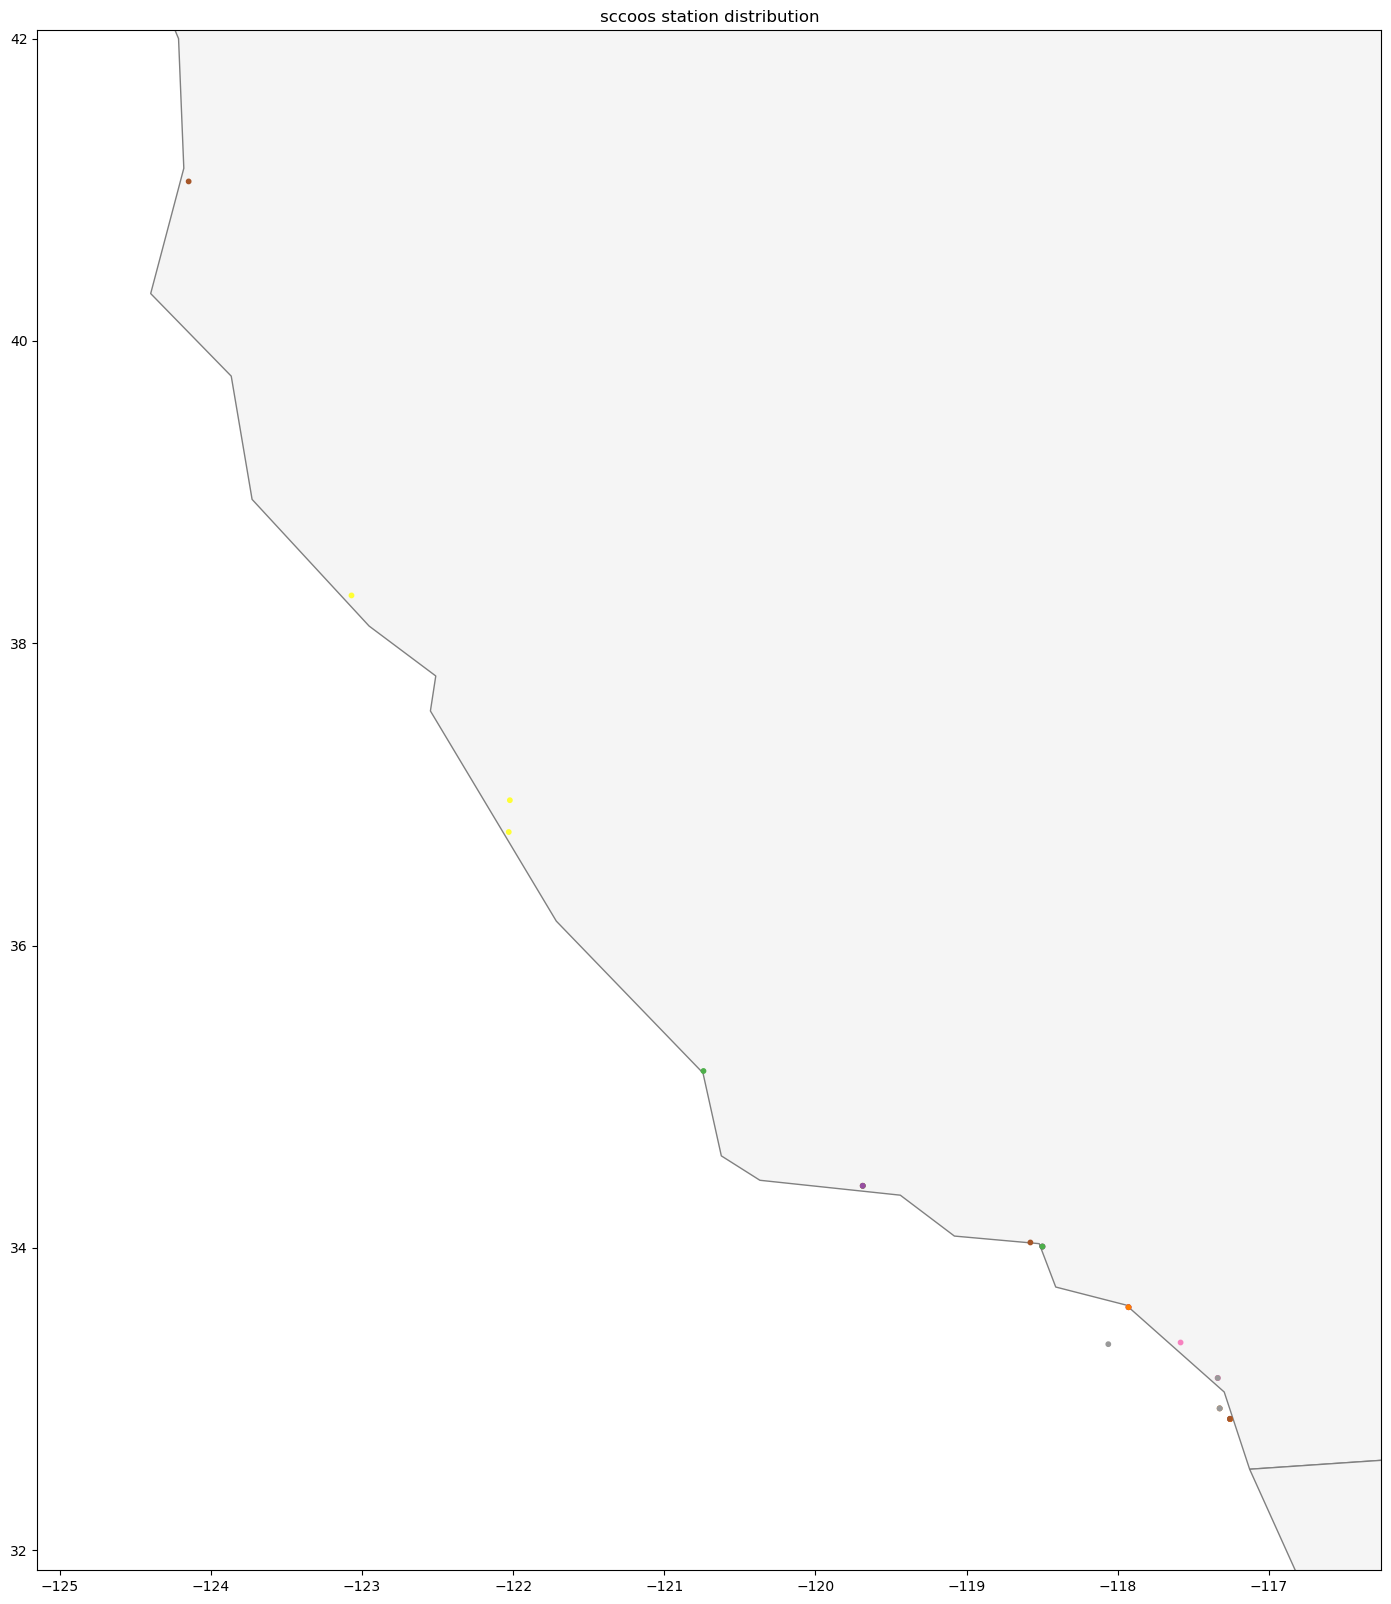

In [31]:
import geopandas
import matplotlib.pyplot as plt

#df = df.loc[df['']]

df.rename(columns=
{'Variable Names + water column depth of measurement in meters [CF_name (# m, # m) or CF_name (mult) or CF_name (# depths)].':
     'Variable Names',
 'Station Deployment (mm/yyyy, yyyy, < 5 yr, > 5 yr)': 'Station Deployment',
 'Longitude (dec deg)': 'Longitude',
 'Latitude (dec deg)': 'Latitude'},
              inplace=True)

df['Station Deployment'] = \
    df['Station Deployment'].astype(str)


gdf = geopandas.GeoDataFrame(
    df, geometry=geopandas.points_from_xy(df['Longitude'], df['Latitude']))

world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))

ax = world.plot(
    color='whitesmoke', 
    edgecolor='grey', 
    figsize=(25,20),
    )

gdf.plot( ax=ax,
         #column='erddap_avail', 
         categorical=True, 
         cmap = 'Set1',
         markersize=10, 
         legend=True,
         legend_kwds={'title': "ERDDAP Available?"},
         k=2,
        )



minx, miny, maxx, maxy = gdf.total_bounds
ax.set_xlim(minx-1, maxx+1)
ax.set_ylim(miny-1, maxy+1)

plt.title('{} station distribution'.format(ra))

plt.show()

Make an interactive map.

When you click on a point the return is the information from the inventory.

In [32]:
gdf_final = gdf.set_crs(epsg=4326)

gdf_final.loc[~gdf_final['geometry'].is_empty == True].drop(columns='Variable Names').explore()#'erddap_avail',cmap = 'Set1')


Configure the ERDDAP to search

In [33]:
with open('utils/ra_erddaps.json') as f:
    urls = json.load(f)

server = urls[ra.lower()]

print(server)

e = ERDDAP(server=server, protocol="tabledap")

https://erddap.sccoos.org/erddap


Search the ERDDAP server for a single station of interest - more of a test

In [34]:
# df['Station ID'].loc[df['Station ID'].isna()] = df.loc[df['Station ID'].isna(),'Dataset ID']

# df['Station ID']

In [35]:
# df_wf = df[df['Station ID'] == 'Jug_Bay']

# # for SCCOOS need to search for 'Station Long Name' as 'Station ID' is NA for most entries
# search_for = df_wf['Station ID'].to_string()

# search_url = e.get_search_url(search_for=search_for, response="csv")

# try:
#     resp = pd.read_csv(search_url)
#     print(resp['Station ID'])
# except:
#     pass

Rip through all the datasets in the inventory and see if they exist on the RA erddap. Process checks the following order:

1. `Station ID`, then 
2. `Station Long Name`, then
3. `WMO ID or NWS/CMAN ID`

We first check if the value is `nan`. If so, we punt as that will return all datasets from the ERDDAP service.

In [36]:
not_found = []
found = dict()

exclude = ' -gliders'


if ra == 'glos':
    search_order = ['Dataset (ERDDAP) ID','Station ID', 'Station Long Name']
elif ra == 'sccoos':
    search_order = ['Station Long Name', 'WMO ID or NWS/CMAN ID', 'Station Description']
else:
    search_order = ['Station ID', 'Station Long Name', 'WMO ID or NWS/CMAN ID']

for search1 in df[search_order[0]].astype(str):

    if search1 == "nan":
        print("punting with %s = nan\n" % search_order[0])
        not_found.append(search1)
        continue
    
    try:
        print('searching \"%s\" = \"%s\"' % (search_order[0], search1))
        search_url = e.get_search_url(search_for=search1+exclude, response="csv")
        resp = pd.read_csv(search_url)
        
        print("Found \"%s\": %s" % (search1,resp['Dataset ID'].values.tolist()))
        
        for dset_id in resp['Dataset ID'].values.tolist():
            if search1.lower() in dset_id.lower():
                found[search1] = {'Dataset ID': [dset_id]}
                print("Keeping \"%s\": %s" % (search1,dset_id))
                #found[search1] = {'Dataset ID': resp['Dataset ID'].values.tolist()}
        
    except:
        
        print('no dataset matching \"%s\"' % search1)
        search2 = df.loc[df[search_order[0]] == search1, search_order[1]].values.tolist()[0]
        
        if search2 == "nan":
                print("punting with %s = nan\n" % search_order[1])
                not_found.append(search1)
                continue
                
        try:
            
            print('searching \"%s\" = \"%s\"' % (search_order[1], search2))
            search_url = e.get_search_url(search_for=search2+exclude, response="csv")
            resp = pd.read_csv(search_url)
            print("Found \"%s\": %s" % (search2,resp['Dataset ID'].values.tolist()))
            
            found[search1] = {'Dataset ID': resp['Dataset ID'].values.tolist()}
            
        except:

            search3 = str(df.loc[df[search_order[0]] == search1, search_order[2]].values.tolist()[0])
            
            if search3 == "nan":
                print("punting with \"%s\" = nan\n" % search_order[2])
                not_found.append(search1)
                continue
            
            try:
                print('searching \"%s\" = \"%s\"' % (search_order[2], search3))
                search_url = e.get_search_url(search_for=search3+exclude, response="csv")
                resp = pd.read_csv(search_url)
                print("Found \"%s\": %s" % (search3,resp['Dataset ID'].values.tolist()))
                
                found[search1] = {'Dataset ID': resp['Dataset ID'].values.tolist()}
                
            except:
                print("Couldn't find:", [search1, search2, search3])
                not_found.append(search1)
        
    print("\n")

searching "Station Long Name" = "Stearns Wharf"
Found "Stearns Wharf": ['HABs-StearnsWharf', 'SPATT-StearnsWharf']


searching "Station Long Name" = "Santa Monica Pier"
Found "Santa Monica Pier": ['HABs-SantaMonicaPier']


searching "Station Long Name" = "Newport Beach Pier"
Found "Newport Beach Pier": ['HABs-NewportBeachPier', 'SPATT-NewportBeachPier']


searching "Station Long Name" = "Scripps Pier"
Found "Scripps Pier": ['HABs-ScrippsPier', 'SPATT-ScrippsPier', 'spc_hab_daily']


searching "Station Long Name" = "Scripps Pier"
Found "Scripps Pier": ['HABs-ScrippsPier', 'SPATT-ScrippsPier', 'spc_hab_daily']


searching "Station Long Name" = "Santa Monica Pier"
Found "Santa Monica Pier": ['HABs-SantaMonicaPier']


searching "Station Long Name" = "Cal Poly Pier"
Found "Cal Poly Pier": ['HABs-CalPolyPier', 'HABs-SantaMonicaPier', 'HABs-ScrippsPier', 'HABs-TrinidadPier', 'HABs-NewportBeachPier', 'spc_hab_daily', 'HABs-Humboldt', 'HABs-SantaCruzWharf', 'HABs-HumboldtSouthBay', 'HABs-Bodega

Print the stations that we couldn't find.

In [37]:
len(not_found)

10

In [38]:
len(found)

0

Show me the record that has NaN for the first search element.

In [39]:
df.loc[df[search_order[0]].isna()]

,RA,Station ID,WMO ID or NWS/CMAN ID,Station Long Name,Station Description,Latitude,Longitude,Platform Type,Station Deployment,"Currently Operational? (Y, N, O, U)",Platform Funder/Sponsor,"RA Funding Involvement (Yf, Yp, N)",Platform Operator/Owner,Operator Sector,Platform Maintainer,Data Manager,Variable Names,Additional notes,geometry


Now show me the stations, with identifiers, that we couldn't find.

In [40]:
df[df[search_order[0]].isin(not_found)]

,RA,Station ID,WMO ID or NWS/CMAN ID,Station Long Name,Station Description,Latitude,Longitude,Platform Type,Station Deployment,"Currently Operational? (Y, N, O, U)",Platform Funder/Sponsor,"RA Funding Involvement (Yf, Yp, N)",Platform Operator/Owner,Operator Sector,Platform Maintainer,Data Manager,Variable Names,Additional notes,geometry
15,SCCOOS,M1,NaN,Power Buoy/M1,CA IFCB Network,36.7511,-122.0292,mooring,2020,Y,SCCOOS/CeNCOOS,Yp,UCSD,Academic,MBARI,Southern California Coastal Ocean Observing Sy...,images,IFCB purchased with funds from OPC; O&M from S...,POINT (-122.02920 36.75110)
18,SCCOOS,HI,NaN,Trinidad Pier/Hog Island,CA IFCB Network,41.055,-124.147,fixed,2020,Y,SCCOOS/CeNCOOS,Yp,UCSD,Academic,Cal Poly Humboldt,Southern California Coastal Ocean Observing Sy...,images,IFCB purchased with funds from OPC; O&M from S...,POINT (-124.14700 41.05500)
19,SCCOOS,NaN,NaN,off SIO Pier,Southern California Acoustic Telemetry Trackin...,32.8696959,-117.2580125,buoy,2023,Y,SCCOOS,Yf,UCSD,Academic,UCSD,Southern California Coastal Ocean Observing Sy...,"sea_water_temperature (sfc and 10m depths), ai...","Innovasea CB250 Data Buoy, aquaMeasure-DOT. Un...",POINT (-117.25801 32.86970)
20,SCCOOS,NaN,NaN,off Topanga Beach (Malibu),Southern California Acoustic Telemetry Trackin...,34.0355668,-118.5782403,buoy,2023,Y,SCCOOS,Yf,UCSD,Academic,UCSD,Southern California Coastal Ocean Observing Sy...,"sea_water_temperature (sfc and 10m depths), ai...","Innovasea CB250 Data Buoy, aquaMeasure-DOT. Un...",POINT (-118.57824 34.03557)
21,SCCOOS,NaN,NaN,San Onofre,Southern California Acoustic Telemetry Trackin...,33.3738998,-117.5846421,buoy,2024,Y,SCCOOS,Yf,UCSD,Academic,UCSD,Southern California Coastal Ocean Observing Sy...,"sea_water_temperature (sfc and 10m depths), ai...","Innovasea CB250 Data Buoy, aquaMeasure-DOT. Un...",POINT (-117.58464 33.37390)
22,SCCOOS,NaN,NaN,Agua Hedionda Lagoon near Carlsbad Aquafarm,Burkeolator,33.139,-117.339,fixed,2014,N,OAP/SCCOOS,Yf,OSU,Academic,UCSD,Southern California Coastal Ocean Observing Sy...,"total_alkalinity (1 m) CO2 (1 m), dissolved_in...",operated by Todd Martz,POINT (-117.33900 33.13900)
23,SCCOOS,NaN,NaN,Agua Hedionda Lagoon near Carlsbad Aquafarm,ACDC Gen 2,33.139,-117.339,fixed,2018,N,OAP/SCCOOS,Yf,UW,Academic,UCSD,Southern California Coastal Ocean Observing Sy...,pCO2 (2 m),operated by Todd Martz,POINT (-117.33900 33.13900)
24,SCCOOS,NaN,NaN,Agua Hedionda Lagoon near Carlsbad Aquafarm,SeapHOx,33.139,-117.339,fixed,2018-04-01 00:00:00,N,OAP/SCCOOS,Yp,UCSD,Academic,UCSD,Southern California Coastal Ocean Observing Sy...,"pH, dissolved_oxygen, temperature, conductivit...","operated by Todd Martz. pH, dissolved oxygen, ...",POINT (-117.33900 33.13900)
25,SCCOOS,NaN,NaN,Catalina Sea Ranch - NOMAD Buoy,ACDC Gen 1,33.3628,-118.0628,buoy,2019,N,OAP/SCCOOS,Yf,UCSD,Academic,UCSD,Southern California Coastal Ocean Observing Sy...,pCO2,operated by Todd Martz,POINT (-118.06280 33.36280)
27,SCCOOS,NaN,NaN,Observing nutrient fluxes and their role in HA...,Wirewalker Profiling System,32.938,-117.326,mooring,2020,N,SCCOOS,Yp,UCSD,Academic,UCSD,Andrew Lucas Lab,"sea_water_temperature (2 m 100 m), sea_water_...","Operated by Lucas, Davis, Send",POINT (-117.32600 32.93800)


Print out all the dataset IDs for the datasets that matched our criteria.

In [41]:
found

{}

Check if each found dataset has coverage for specified CY

In [42]:
valid_datasets = []

cy = '2024'
n=0
for key in found:
    
    print(f'testing {key}')
    
    dataset_id = found[key]['Dataset ID'] #+" "+found[key]['Station ID']
    
    if (len(dataset_id)>1):
        
        for dataset in dataset_id:
            n+=1
            if (n<3):
                e.dataset_id = dataset
        
                e.constraints = {
                    "time>=": "{}-01-01".format(cy)
                }
            
                e.variables = ['time']
        
                try:
                    df_data = e.to_pandas(parse_dates=True)
                    valid_datasets.extend([key])
                    
                except:

                    print(f'No data for {cy} for {key}: dataset ID {e.dataset_id}')# % (key,e.dataset_id))

                    pass

                

    else:
        
        e.dataset_id = dataset_id[0]
    
        e.constraints = {
                         "time>=": "{}-01-01".format(cy)
                        }
        
        e.variables = ['time']
        
        try:
            
            df_data = e.to_pandas(parse_dates=True)

            valid_datasets.extend([key])

        except:

            print(f'No data for {cy} for {key}: dataset ID {e.dataset_id}')# % (key,e.dataset_id))
            
            pass

            #print("No data for 2021 for %s: dataset ID %s" % (key,e.dataset_id))

            
#for valid in sorted(set(valid_datasets)):
    
#     # drop qc vars
#     cols = [c for c in df_data.columns if 'qc' not in c]
#     cols = [c for c in cols if 'QARTOD' not in c]

#     df_data = df_data[cols]

#     # set index for plotting
#     df_data = df_data.set_index(df_data['time (UTC)'])

#     # plot
#     #df_data.plot(subplots=True, title=e.dataset_id,figsize=(20,20))

#     start_time = df_data['time (UTC)'].min()
#     end_time = df_data['time (UTC)'].max()

#     print('Dataset %s' % e.dataset_id)
#     print('Duration: %s - %s' % (start_time, end_time))

no_cov_datasets = found.keys() - sorted(set(valid_datasets))

print('Datasets without coverage for {}:\n{}'.format(cy,no_cov_datasets))

Datasets without coverage for 2024:
set()


Show me the inventory metadata about the invalid stations:

In [43]:
bad_stations = df.loc[(df[search_order[0]].isin(no_cov_datasets)) | df[search_order[0]].isin(not_found)]

df['erddap_not_avail'] = df[search_order[0]].isin(bad_stations[search_order[0]])

df.loc[df['erddap_not_avail']]

,RA,Station ID,WMO ID or NWS/CMAN ID,Station Long Name,Station Description,Latitude,Longitude,Platform Type,Station Deployment,"Currently Operational? (Y, N, O, U)",Platform Funder/Sponsor,"RA Funding Involvement (Yf, Yp, N)",Platform Operator/Owner,Operator Sector,Platform Maintainer,Data Manager,Variable Names,Additional notes,geometry,erddap_not_avail
15,SCCOOS,M1,NaN,Power Buoy/M1,CA IFCB Network,36.7511,-122.0292,mooring,2020,Y,SCCOOS/CeNCOOS,Yp,UCSD,Academic,MBARI,Southern California Coastal Ocean Observing Sy...,images,IFCB purchased with funds from OPC; O&M from S...,POINT (-122.02920 36.75110),True
18,SCCOOS,HI,NaN,Trinidad Pier/Hog Island,CA IFCB Network,41.055,-124.147,fixed,2020,Y,SCCOOS/CeNCOOS,Yp,UCSD,Academic,Cal Poly Humboldt,Southern California Coastal Ocean Observing Sy...,images,IFCB purchased with funds from OPC; O&M from S...,POINT (-124.14700 41.05500),True
19,SCCOOS,NaN,NaN,off SIO Pier,Southern California Acoustic Telemetry Trackin...,32.8696959,-117.2580125,buoy,2023,Y,SCCOOS,Yf,UCSD,Academic,UCSD,Southern California Coastal Ocean Observing Sy...,"sea_water_temperature (sfc and 10m depths), ai...","Innovasea CB250 Data Buoy, aquaMeasure-DOT. Un...",POINT (-117.25801 32.86970),True
20,SCCOOS,NaN,NaN,off Topanga Beach (Malibu),Southern California Acoustic Telemetry Trackin...,34.0355668,-118.5782403,buoy,2023,Y,SCCOOS,Yf,UCSD,Academic,UCSD,Southern California Coastal Ocean Observing Sy...,"sea_water_temperature (sfc and 10m depths), ai...","Innovasea CB250 Data Buoy, aquaMeasure-DOT. Un...",POINT (-118.57824 34.03557),True
21,SCCOOS,NaN,NaN,San Onofre,Southern California Acoustic Telemetry Trackin...,33.3738998,-117.5846421,buoy,2024,Y,SCCOOS,Yf,UCSD,Academic,UCSD,Southern California Coastal Ocean Observing Sy...,"sea_water_temperature (sfc and 10m depths), ai...","Innovasea CB250 Data Buoy, aquaMeasure-DOT. Un...",POINT (-117.58464 33.37390),True
22,SCCOOS,NaN,NaN,Agua Hedionda Lagoon near Carlsbad Aquafarm,Burkeolator,33.139,-117.339,fixed,2014,N,OAP/SCCOOS,Yf,OSU,Academic,UCSD,Southern California Coastal Ocean Observing Sy...,"total_alkalinity (1 m) CO2 (1 m), dissolved_in...",operated by Todd Martz,POINT (-117.33900 33.13900),True
23,SCCOOS,NaN,NaN,Agua Hedionda Lagoon near Carlsbad Aquafarm,ACDC Gen 2,33.139,-117.339,fixed,2018,N,OAP/SCCOOS,Yf,UW,Academic,UCSD,Southern California Coastal Ocean Observing Sy...,pCO2 (2 m),operated by Todd Martz,POINT (-117.33900 33.13900),True
24,SCCOOS,NaN,NaN,Agua Hedionda Lagoon near Carlsbad Aquafarm,SeapHOx,33.139,-117.339,fixed,2018-04-01 00:00:00,N,OAP/SCCOOS,Yp,UCSD,Academic,UCSD,Southern California Coastal Ocean Observing Sy...,"pH, dissolved_oxygen, temperature, conductivit...","operated by Todd Martz. pH, dissolved oxygen, ...",POINT (-117.33900 33.13900),True
25,SCCOOS,NaN,NaN,Catalina Sea Ranch - NOMAD Buoy,ACDC Gen 1,33.3628,-118.0628,buoy,2019,N,OAP/SCCOOS,Yf,UCSD,Academic,UCSD,Southern California Coastal Ocean Observing Sy...,pCO2,operated by Todd Martz,POINT (-118.06280 33.36280),True
27,SCCOOS,NaN,NaN,Observing nutrient fluxes and their role in HA...,Wirewalker Profiling System,32.938,-117.326,mooring,2020,N,SCCOOS,Yp,UCSD,Academic,UCSD,Andrew Lucas Lab,"sea_water_temperature (2 m 100 m), sea_water_...","Operated by Lucas, Davis, Send",POINT (-117.32600 32.93800),True


Invert the `erddap_not_avail` column and drop it.

In [44]:
df['erddap_avail'] = ~df['erddap_not_avail']

df.drop(columns='erddap_not_avail', inplace=True)

df

,RA,Station ID,WMO ID or NWS/CMAN ID,Station Long Name,Station Description,Latitude,Longitude,Platform Type,Station Deployment,"Currently Operational? (Y, N, O, U)",Platform Funder/Sponsor,"RA Funding Involvement (Yf, Yp, N)",Platform Operator/Owner,Operator Sector,Platform Maintainer,Data Manager,Variable Names,Additional notes,geometry,erddap_avail
0,SCCOOS,SW,TNWC1,Stearns Wharf,Automated Shore Station,34.4107,-119.6874,fixed,2005,Y,SCCOOS,Yf,UCSD,Academic,UCSD,Southern California Coastal Ocean Observing Sy...,"sea_water_temperature (2m), sea_water_pressure...",WMO ID In process. operated by Melissa Carter,POINT (-119.68740 34.41070),True
1,SCCOOS,SMP,NaN,Santa Monica Pier,Automated Shore Station,34.0086,-118.4986,fixed,2005,Y,SCCOOS/City of LA/Santa Monica Bay Foundation,Yp,UCSD,Academic,UCSD,Southern California Coastal Ocean Observing Sy...,"sea_water_temperature (2m), sea_water_pressure...",WMO ID In process. operated by Melissa Carter,POINT (-118.49860 34.00860),True
2,SCCOOS,NBP,NEWC1,Newport Beach Pier,Automated Shore Station,33.6073,-117.9289,fixed,2005,Y,SCCOOS,Yf,UCSD,Academic,UCSD,Southern California Coastal Ocean Observing Sy...,"sea_water_temperature (2m), sea_water_pressure...",WMO ID In process. operated by Melissa Carter,POINT (-117.92890 33.60730),True
3,SCCOOS,SP,LJSC1,Scripps Pier,Automated Shore Station,32.867,-117.257,fixed,2005,Y,SCCOOS,Yf,UCSD,Academic,UCSD,Southern California Coastal Ocean Observing Sy...,"sea_water_temperature (2m), sea_water_pressure...",WMO ID In process. operated by Melissa Carter,POINT (-117.25700 32.86700),True
4,SCCOOS,SP,LJSC1,Scripps Pier,OAH Monitoring (SASS with SCS),32.867,-117.257,fixed,2022,Y,SCCOOS,Yf,UCSD,Academic,UCSD,Southern California Coastal Ocean Observing Sy...,"pH, dissolved_oxygen, temperature, conductivit...",Self-calibrating seaphox. PI: Todd Martz,POINT (-117.25700 32.86700),True
5,SCCOOS,SMP,NaN,Santa Monica Pier,OAH Monitoring (SASS with SCS),34.0086,-118.4986,fixed,2024,Y,SCCOOS,Yf,UCSD,Academic,UCSD,Southern California Coastal Ocean Observing Sy...,"pH, dissolved_oxygen, temperature, conductivit...",Self-calibrating seaphox. PI: Todd Martz,POINT (-118.49860 34.00860),True
6,SCCOOS,CPP,NaN,Cal Poly Pier,Harmful Algae Bloom monitoring program station,35.17,-120.741,sampling_location,2005,Y,SCCOOS,Yf,UCSD,Academic,Cal Poly,Southern California Coastal Ocean Observing Sy...,"sea_water_temperature, mass_concentration_of_c...",Data management under development haven't appl...,POINT (-120.74100 35.17000),True
7,SCCOOS,SW,NaN,Stearns Wharf,Harmful Algae Bloom monitoring program station,34.4107,-119.6874,sampling_location,2005,Y,SCCOOS,Yf,UCSD,Academic,UCSB,Southern California Coastal Ocean Observing Sy...,"sea_water_temperature, mass_concentration_of_c...",Data management under development haven't appl...,POINT (-119.68740 34.41070),True
8,SCCOOS,SMP,NaN,Santa Monica Pier,Harmful Algae Bloom monitoring program station,34.0086,-118.4986,sampling_location,2005,Y,SCCOOS,Yf,UCSD,Academic,UCLA,Southern California Coastal Ocean Observing Sy...,"sea_water_temperature, mass_concentration_of_c...",Data management under development haven't appl...,POINT (-118.49860 34.00860),True
9,SCCOOS,NBP,NaN,Newport Beach Pier,Harmful Algae Bloom monitoring program station,33.6073,-117.9289,sampling_location,2005,Y,SCCOOS,Yf,UCSD,Academic,USC,Southern California Coastal Ocean Observing Sy...,"sea_water_temperature, mass_concentration_of_c...",Data management under development haven't appl...,POINT (-117.92890 33.60730),True


Make a plot of all points and color based on ERDDAP available or not.

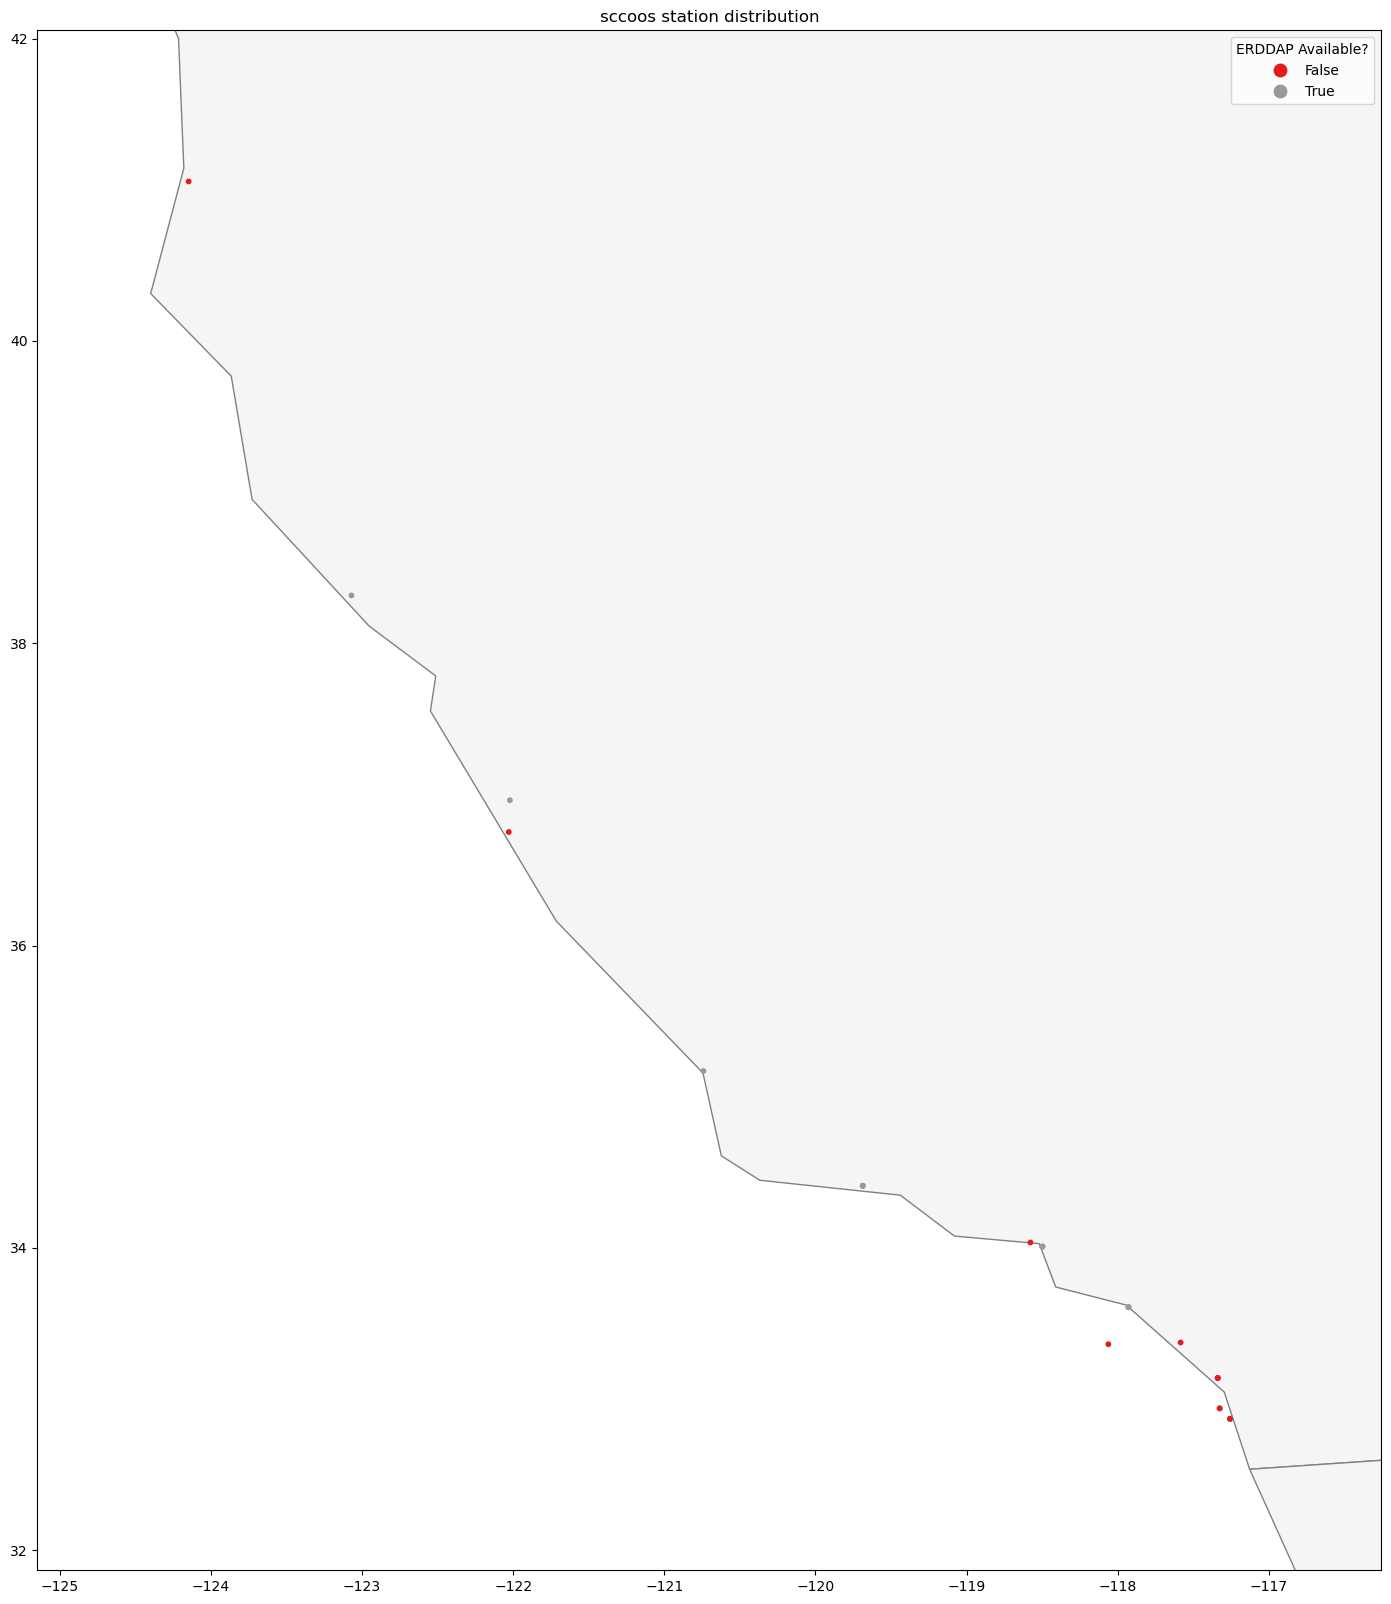

In [45]:
import geopandas
import matplotlib.pyplot as plt

#df = df.loc[df['']]

df.rename(columns=
{'Variable Names + water column depth of measurement in meters [CF_name (# m, # m) or CF_name (mult) or CF_name (# depths)].':
     'Variable Names',
 'Station Deployment (mm/yyyy, yyyy, < 5 yr, > 5 yr)': 'Station Deployment',
 'Longitude (dec deg)': 'Longitude',
 'Latitude (dec deg)': 'Latitude'},
              inplace=True)

df['Station Deployment'] = \
    df['Station Deployment'].astype(str)


gdf = geopandas.GeoDataFrame(
    df, geometry=geopandas.points_from_xy(df['Longitude'], df['Latitude']))

world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))

ax = world.plot(
    color='whitesmoke', 
    edgecolor='grey', 
    figsize=(25,20),
    )

gdf.plot( ax=ax,
         column='erddap_avail', 
         categorical=True, 
         cmap = 'Set1',
         markersize=10, 
         legend=True,
         legend_kwds={'title': "ERDDAP Available?"},
         k=2,
        )



minx, miny, maxx, maxy = gdf.total_bounds
ax.set_xlim(minx-1, maxx+1)
ax.set_ylim(miny-1, maxy+1)

plt.title('{} station distribution'.format(ra))

plt.show()

Make an interactive map.

When you click on a point the return is the information from the inventory.

In [46]:
gdf_final = gdf.set_crs(epsg=4326)

gdf_final.loc[~gdf_final['geometry'].is_empty == True].drop(columns='Variable Names').explore('erddap_avail',cmap = 'Set1', style_kwds={"radius":5})


## Show me some bad coordinates

_if there are any_

In [47]:
gdf_final.loc[gdf_final['geometry'].is_empty == True]

,RA,Station ID,WMO ID or NWS/CMAN ID,Station Long Name,Station Description,Latitude,Longitude,Platform Type,Station Deployment,"Currently Operational? (Y, N, O, U)",Platform Funder/Sponsor,"RA Funding Involvement (Yf, Yp, N)",Platform Operator/Owner,Operator Sector,Platform Maintainer,Data Manager,Variable Names,Additional notes,geometry,erddap_avail


In [48]:
# import urllib.request
# for url in gdf_final.loc[gdf_final['erddap_not_avail'],'Station Description'].str.replace('url: ',''):
#     print(url)
#     try:
#         urllib.request.urlopen(url).getcode()
#     except:
#         print("URL broken: %s" % url)
#         print(gdf_final.loc[gdf_final['Station Description'].str.contains(url,regex=False),'Station ID'])

# Show me the stations where ERDDAP doesn't exist or provide a valid response.

Reasons:
* Station not found on RA erddap
* dataset found but no data for this CY.

In [49]:
gdf_final.loc[~gdf_final['erddap_avail']]

,RA,Station ID,WMO ID or NWS/CMAN ID,Station Long Name,Station Description,Latitude,Longitude,Platform Type,Station Deployment,"Currently Operational? (Y, N, O, U)",Platform Funder/Sponsor,"RA Funding Involvement (Yf, Yp, N)",Platform Operator/Owner,Operator Sector,Platform Maintainer,Data Manager,Variable Names,Additional notes,geometry,erddap_avail
15,SCCOOS,M1,NaN,Power Buoy/M1,CA IFCB Network,36.7511,-122.0292,mooring,2020,Y,SCCOOS/CeNCOOS,Yp,UCSD,Academic,MBARI,Southern California Coastal Ocean Observing Sy...,images,IFCB purchased with funds from OPC; O&M from S...,POINT (-122.02920 36.75110),False
18,SCCOOS,HI,NaN,Trinidad Pier/Hog Island,CA IFCB Network,41.055,-124.147,fixed,2020,Y,SCCOOS/CeNCOOS,Yp,UCSD,Academic,Cal Poly Humboldt,Southern California Coastal Ocean Observing Sy...,images,IFCB purchased with funds from OPC; O&M from S...,POINT (-124.14700 41.05500),False
19,SCCOOS,NaN,NaN,off SIO Pier,Southern California Acoustic Telemetry Trackin...,32.8696959,-117.2580125,buoy,2023,Y,SCCOOS,Yf,UCSD,Academic,UCSD,Southern California Coastal Ocean Observing Sy...,"sea_water_temperature (sfc and 10m depths), ai...","Innovasea CB250 Data Buoy, aquaMeasure-DOT. Un...",POINT (-117.25801 32.86970),False
20,SCCOOS,NaN,NaN,off Topanga Beach (Malibu),Southern California Acoustic Telemetry Trackin...,34.0355668,-118.5782403,buoy,2023,Y,SCCOOS,Yf,UCSD,Academic,UCSD,Southern California Coastal Ocean Observing Sy...,"sea_water_temperature (sfc and 10m depths), ai...","Innovasea CB250 Data Buoy, aquaMeasure-DOT. Un...",POINT (-118.57824 34.03557),False
21,SCCOOS,NaN,NaN,San Onofre,Southern California Acoustic Telemetry Trackin...,33.3738998,-117.5846421,buoy,2024,Y,SCCOOS,Yf,UCSD,Academic,UCSD,Southern California Coastal Ocean Observing Sy...,"sea_water_temperature (sfc and 10m depths), ai...","Innovasea CB250 Data Buoy, aquaMeasure-DOT. Un...",POINT (-117.58464 33.37390),False
22,SCCOOS,NaN,NaN,Agua Hedionda Lagoon near Carlsbad Aquafarm,Burkeolator,33.139,-117.339,fixed,2014,N,OAP/SCCOOS,Yf,OSU,Academic,UCSD,Southern California Coastal Ocean Observing Sy...,"total_alkalinity (1 m) CO2 (1 m), dissolved_in...",operated by Todd Martz,POINT (-117.33900 33.13900),False
23,SCCOOS,NaN,NaN,Agua Hedionda Lagoon near Carlsbad Aquafarm,ACDC Gen 2,33.139,-117.339,fixed,2018,N,OAP/SCCOOS,Yf,UW,Academic,UCSD,Southern California Coastal Ocean Observing Sy...,pCO2 (2 m),operated by Todd Martz,POINT (-117.33900 33.13900),False
24,SCCOOS,NaN,NaN,Agua Hedionda Lagoon near Carlsbad Aquafarm,SeapHOx,33.139,-117.339,fixed,2018-04-01 00:00:00,N,OAP/SCCOOS,Yp,UCSD,Academic,UCSD,Southern California Coastal Ocean Observing Sy...,"pH, dissolved_oxygen, temperature, conductivit...","operated by Todd Martz. pH, dissolved oxygen, ...",POINT (-117.33900 33.13900),False
25,SCCOOS,NaN,NaN,Catalina Sea Ranch - NOMAD Buoy,ACDC Gen 1,33.3628,-118.0628,buoy,2019,N,OAP/SCCOOS,Yf,UCSD,Academic,UCSD,Southern California Coastal Ocean Observing Sy...,pCO2,operated by Todd Martz,POINT (-118.06280 33.36280),False
27,SCCOOS,NaN,NaN,Observing nutrient fluxes and their role in HA...,Wirewalker Profiling System,32.938,-117.326,mooring,2020,N,SCCOOS,Yp,UCSD,Academic,UCSD,Andrew Lucas Lab,"sea_water_temperature (2 m 100 m), sea_water_...","Operated by Lucas, Davis, Send",POINT (-117.32600 32.93800),False


# Do some checking against the IOOS catalog

only for datasets that we couldn't find in ERDDAP (per above)

In [50]:
from ckanapi import RemoteCKAN
import xarray as xr

problem_datasets = []

ua = 'ckanapiioos/1.0 (+https://ioos.us/)'

#ioos_catalog = RemoteCKAN('https://data.ioos.us', user_agent=ua, get_only=True)
ioos_catalog = RemoteCKAN('https://data.ioos.us', user_agent=ua)
ioos_catalog

gdf_ckan = gdf_final.loc[~gdf_final['erddap_avail']]

for station in gdf_ckan['Station ID'].dropna():

    RA = gdf_ckan.loc[gdf_ckan['Station ID']==station,'RA'].tolist()[0]
    
    print('Station "{}" + RA "{}"'.format(station.lower(), RA.lower()))
    
    # build RA tag query
    fq = '+organization:{}'.format(RA.lower())

    # build free text query
    q = "\""+station.lower()+"\""+" -glider"

    query = ioos_catalog.address + '/dataset/?' + 'q=' + q + '&organization=' + RA.lower()
    
    print('Query: {}'.format(query.replace(" ","%20")))

    datasets = ioos_catalog.action.package_search(q=q, fq=fq)

    

    if datasets['count'] > 0:
        print('\tfound {} dataset(s):'.format(datasets['count']))
        
        for dataset in datasets['results']:
            print('\t',dataset['title'])
            
            
            if dataset['resources']:
                print('\t',dataset['resources'][0]['url'])

                start_date = next(item for item in dataset["extras"] if item["key"] == "temporal-extent-begin")['value']
                end_date = next(item for item in dataset["extras"] if item["key"] == "temporal-extent-end")['value']

                print('\t','Coverage Meta:\n\t\t', start_date,' - ',end_date,'\n')

                if 'thredds' in dataset['resources'][0]['url']:
                    ds = xr.open_dataset(dataset['resources'][0]['url'])

                    time_max = ds.time.max().values

                    time_min = ds.time.min().values


                    print('\tCoverage Data:\n\t\t', time_min,' - ',time_max, '\n')

                    if pd.to_datetime(end_date) < pd.to_datetime(time_max, utc=True):
                        test_date = pd.to_datetime(time_max, utc=True)

                else:
                    test_date = pd.to_datetime(end_date, utc=True)

                if test_date > pd.to_datetime('{}-01-01'.format(cy), utc=True):
                    print('\t{} is valid.'.format(station))
                    break
                else:
                    print('\t{} is not valid.'.format(station))

                    problem_datasets.append(station)
            
            else:
                print('\t{} missing additional metadata'.format(station))
                problem_datasets.append(station)
    else:
        print("\tNo datasets found!")
        problem_datasets.append(station)

Station "m1" + RA "sccoos"
Query: https://data.ioos.us/dataset/?q="m1"%20-glider&organization=sccoos
	found 19 dataset(s):
	 Del Mar Nearshore Mooring Salinity Data *** PRELIMINARY, No QA/QC info ***
	 https://erddap.sccoos.org/erddap/tabledap/delmar_salinity
	 Coverage Meta:
		 2006-02-28T09:20:00Z  -  2022-05-18T22:20:00Z 

	M1 is not valid.
	 Del Mar Nearshore Mooring Temperature Data *** PRELIMINARY, No QA/QC info ***
	 https://erddap.sccoos.org/erddap/tabledap/delmar_temperature
	 Coverage Meta:
		 2006-02-28T09:20:00Z  -  2022-05-18T22:20:00Z 

	M1 is not valid.
	 CalHABMAP - HABs Newport Beach Pier data
	 https://erddap.sccoos.org/erddap/tabledap/HABs-NewportBeachPier
	 Coverage Meta:
		 2008-06-30T16:20:00Z  -  2025-06-23T17:30:00Z 

	M1 is valid.
Station "hi" + RA "sccoos"
Query: https://data.ioos.us/dataset/?q="hi"%20-glider&organization=sccoos
	No datasets found!


Check the datasets that didn't have coverage in ERDDAP or through IOOS catalog and see if they are **Currently Operational?**

In [51]:
gdf_ckan.loc[gdf_ckan['Station ID'].isin(problem_datasets)]

,RA,Station ID,WMO ID or NWS/CMAN ID,Station Long Name,Station Description,Latitude,Longitude,Platform Type,Station Deployment,"Currently Operational? (Y, N, O, U)",Platform Funder/Sponsor,"RA Funding Involvement (Yf, Yp, N)",Platform Operator/Owner,Operator Sector,Platform Maintainer,Data Manager,Variable Names,Additional notes,geometry,erddap_avail
15,SCCOOS,M1,NaN,Power Buoy/M1,CA IFCB Network,36.7511,-122.0292,mooring,2020,Y,SCCOOS/CeNCOOS,Yp,UCSD,Academic,MBARI,Southern California Coastal Ocean Observing Sy...,images,IFCB purchased with funds from OPC; O&M from S...,POINT (-122.02920 36.75110),False
18,SCCOOS,HI,NaN,Trinidad Pier/Hog Island,CA IFCB Network,41.055,-124.147,fixed,2020,Y,SCCOOS/CeNCOOS,Yp,UCSD,Academic,Cal Poly Humboldt,Southern California Coastal Ocean Observing Sy...,images,IFCB purchased with funds from OPC; O&M from S...,POINT (-124.14700 41.05500),False


Print out the available metadata from the IOOS Catalog for the last dataset.

In [52]:
dataset

{'author': None,
 'author_email': None,
 'creator_user_id': '0ea3933c-4674-41dd-a17d-bfbc8c99bd75',
 'id': 'b1eeef81-d29d-4a1f-bdd4-e1728055b319',
 'isopen': False,
 'license_id': None,
 'license_title': None,
 'maintainer': None,
 'maintainer_email': None,
 'metadata_created': '2025-01-10T15:05:50.814606',
 'metadata_modified': '2025-06-27T16:07:32.041833',
 'name': 'calhabmap-habs-newport-beach-pier-data',
 'notes': 'The California Harmful Algal Bloom Monitoring and Alert Program (CalHABMAP) collects weekly phytoplankton and water quality data at eight piers along the Central and Southern California coast. HABMAP provides timely updates on HAB events, and aids in understanding the timing, extent, and impact of these events on humans and the marine ecosystem.',
 'num_resources': 6,
 'num_tags': 113,
 'organization': {'id': '1ece450e-35e1-438c-a467-4f5417a231d0',
  'name': 'sccoos',
  'title': 'SCCOOS',
  'type': 'organization',
  'description': 'SCCOOS brings together coastal observat

In [53]:
# GLOS special case as they provide ERDDAP ID

# for dataset in gdf_final.loc[(~gdf_final['erddap_avail'] & ~gdf_final['Dataset (ERDDAP) ID'].isna()),'Dataset (ERDDAP) ID'].tolist():
#     print(dataset)
#     e.dataset_id = dataset
    
#     e.constraints = {
#                  "time>=": "{}-01-01".format(cy)
#             }
        
#     e.variables = ['time']
    
#     try:
        
#         df_data = e.to_pandas(parse_dates=True)
        
#         string = '\tDate range: {} - {}'.format(df_data.min()[0],df_data.max()[0])
        
#         print(string)
        
#         if pd.to_datetime(df_data.max()[0], utc=True) > pd.to_datetime('{}-01-01'.format(cy), utc=True):
            
#             datasetid = gdf_final.loc[gdf_final['Dataset (ERDDAP) ID']==dataset,'Station ID'].tolist()[0]
            
#             problem_datasets.remove(datasetid)
        
#     except:
#         print('\tNo valid data')

In [54]:
#gdf_ckan.loc[gdf_ckan['Station ID'].isin(problem_datasets)]